# Using Simons CMAP to decompose the SeaFlow time series and estimate diel variation over cruises

This notebook provides a specific example in using SeaFlow data and colocalized variables from CMAP to run a time series model. The aim is to address a research question in diel variation with cell size for populations of Prochlorococcus and Synechococcus. 
> How does cell size vary on a daily cycle across different cruises and environmental conditions?

Using data queried and colocalized from different sources in CMAP, we can easily integrate them together to begin the analysis! 

In [21]:
import os
import pandas as pd
import numpy as np
import plotnine as p9
import pycmap
from scipy import stats
import re
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from diel_tools import *
from tsd_functions import *
import warnings
import seaborn as sns
from dateutil.parser import parse
import datetime
# suppress warnings, i know they're there but i don't care!
warnings.simplefilter('ignore')

## SeaFlow Data Retrieval through CMAP

In [ ]:
## call CMAP to get seaflow datasets
key =!tail ".cmap_key"    # reading the last line from a file using a system command
api = pycmap.API(token=key[1]) 

In [26]:
# grab seaflow data from api, grouped on an hourly basis (thanks diana!)
qry="""SELECT DATEFROMPARTS(YEAR(time),MONTH(time),DAY(time)) Date
,DATEPART(HOUR, time) Hour
,avg(lat)lat
,avg(CASE WHEN (cruise = 'Tokyo_4' AND DAY(time)=31 AND DATEPART(HOUR,time)=13 and lon <0) OR
               (cruise = 'Tokyo_3' AND DAY(time)=27 AND DATEPART(HOUR,time)=2 and lon <0) OR
               (cruise = 'SR1917' AND DAY(time)=16 AND DATEPART(HOUR,time)=0 and lon <0) 
        THEN lon+360 ELSE lon END) lon
--,avg(CASE WHEN lon <0 THEN lon+360 ELSE lon END) lon
,avg(depth)depth
,cruise
,avg(ISNULL(abundance_prochloro,0))abundance_prochloro
,avg(ISNULL(abundance_synecho,0))abundance_synecho
,avg(ISNULL(abundance_picoeuk,0))abundance_picoeuk
,avg(ISNULL(abundance_croco,0))abundance_croco
,avg(ISNULL(diam_prochloro,0))diam_prochloro
,avg(ISNULL(diam_synecho,0))diam_synecho
,avg(ISNULL(diam_picoeuk,0))diam_picoeuk
,avg(ISNULL(diam_croco,0))diam_croco
,avg(ISNULL(Qc_prochloro,0))Qc_prochloro
,avg(ISNULL(Qc_synecho,0))Qc_synecho
,avg(ISNULL(Qc_picoeuk,0))Qc_picoeuk
,avg(ISNULL(Qc_croco,0))Qc_croco
,avg(ISNULL(biomass_prochloro,0))biomass_prochloro
,avg(ISNULL(biomass_synecho,0))biomass_synecho
,avg(ISNULL(biomass_picoeuk,0))biomass_picoeuk
,avg(ISNULL(biomass_croco,0))biomass_croco
  FROM tblSeaFlow_v1_5
where  time <> '2019-11-16 00:45:05.000' -- Removing single point from cruise SR1917 with lon at -144
GROUP BY cruise,  DATEFROMPARTS(YEAR(time),MONTH(time),DAY(time)),
DATEPART(HOUR, time)
ORDER BY cruise,  DATEFROMPARTS(YEAR(time),MONTH(time),DAY(time))"""
seaflow_hourly = api.query(qry)

## Colocalization for PAR [MODIS](https://simonscmap.com/catalog/datasets/MODIS%20PAR) and Temperature [GHRSST](https://simonscmap.com/catalog/datasets/Near_Real_Time%20SST_AVHRR_OI) data

In [27]:
# reararange time columns
timecols = ['Year', 'Month', 'Day', 'Hour']
seaflow_hourly['time'] = pd.to_datetime(seaflow_hourly[timecols]).dt.strftime('%Y-%m-%d-%H:00:00')
seaflow_hourly.drop(columns=timecols, inplace=True)
# adjust longitude for CMAP colocalization
seaflow_hourly['lon']=np.where(seaflow_hourly['lon'] > 180, 
                               seaflow_hourly['lon'] - 360, 
                               seaflow_hourly['lon'])

In [5]:
# colocalize on satellite PAR and temp with hourly seaflow data- may take around 10-15 min to run
targets = {
    'tblModis_PAR' : {
        'variables': ['PAR'],
        'tolerances': [1, 0.25, 0.25, 5]
    },
    "tblSST_AVHRR_OI_NRT": {
        "variables": ["sst"],
        "tolerances": [1, 0.25, 0.25, 5]
    },
}

# run custom colocalization
coloc_samp = pycmap.Sample(
              source=seaflow_hourly, 
              targets=targets, 
              replaceWithMonthlyClimatolog=True
             )

Gathering metadata .... 
Sampling starts.
10608 / 10612 ... sampling tblSST_AVHRR_OI_NRT10605 / 10612 ... sampling tblSST_AVHRR_OI_NRT... sampling tblModis_PARg tblSST_AVHRR_OI_NRTsampling tblSST_AVHRR_OI_NRTdis_PAR9647 / 10612 ... sampling tblModis_PAR9661 / 10612 ... sampling tblModis_PAR9669 / 10612 ... sampling tblModis_PAR9725 / 10612 ... sampling tblModis_PAR9726 / 10612 ... sampling tblModis_PAR9722 / 10612 ... sampling tblSST_AVHRR_OI_NRT9739 / 10612 ... sampling tblSST_AVHRR_OI_NRT9737 / 10612 ... sampling tblSST_AVHRR_OI_NRT9742 / 10612 ... sampling tblSST_AVHRR_OI_NRT9746 / 10612 ... sampling tblSST_AVHRR_OI_NRT9774 / 10612 ... sampling tblModis_PAR9788 / 10612 ... sampling tblModis_PAR9797 / 10612 ... sampling tblModis_PAR9794 / 10612 ... sampling tblSST_AVHRR_OI_NRT9843 / 10612 ... sampling tblSST_AVHRR_OI_NRT9891 / 10612 ... sampling tblModis_PAR9908 / 10612 ... sampling tblSST_AVHRR_OI_NRT9937 / 10612 ... sampling tblSST_AVHRR_OI_NRT9959 / 10612 ... sampling tblModis_PAR

In [7]:
# save the original colocalized object just in case of disasters
hourly_samp = coloc_samp.copy()
# fix time to be in the right format
hourly_samp['time']=pd.DatetimeIndex(hourly_samp['time']).tz_convert('UTC')
# fix some column names to be more readable
hourly_samp.rename(columns={'CMAP_PAR_tblModis_PAR':'par','CMAP_sst_tblSST_AVHRR_OI_NRT':'temp'},inplace=True)

### Cleaning to get the data in the right shape and format

In [13]:
# melt data from wide to long
hourly_samp['id'] = hourly_samp.index
long_sf = pd.wide_to_long(hourly_samp, stubnames=['abundance', 'diam', 'Qc', 'biomass',],
                sep='_',
                i='id', 
                j='pop',
               suffix='\w+').reset_index().drop(columns=['id']).rename(columns={'diam':'diam_med'})

## Where did SeaFlow go?
#### Mostly the N. Pacific!

In [15]:
# switch longitudes back
hourly_samp['lon']=np.where(hourly_samp['lon'] < 0, hourly_samp['lon'] + 360, hourly_samp['lon'])
# plot daily averages to not explode plotly
daily = hourly_samp.groupby([pd.Grouper(key='time',freq='24H'), 'cruise']).mean().reset_index()
px.scatter_geo(daily, lat='lat',lon='lon',color='cruise', title='Daily SeaFlow Cruise Tracks')

## What does the distribution of SeaFlow estimated diameter look like for different populations?

In [17]:
hist_data = [hourly_samp['diam_prochloro'], hourly_samp['diam_synecho'], 
             hourly_samp['diam_picoeuk']]
group_labels = ['pro','syn','picoeuk'] # name of the dataset

# create plot
fig = ff.create_distplot(hist_data, group_labels, bin_size=.01,show_rug=False, histnorm='probability')
# add x/ylabels and title
fig.update_layout(
    title="Pro and Syn Probability Distributions",
    xaxis_title="Median Diameter (µm)",
    yaxis_title="Probability",
    legend_title="Population"
)
fig.show()

## Now we'll run a time series decomposition (TSD) model to deconvolve our cruise time series into different components!
### Here, the run_TSD function will linearly interpolate the values before running the data on a rolling hourly basis for 3 day chunks
This model is a multiplicative function, which can be written as: 
$$Y_t = T_t * S_t * R_t $$
which can also be written as:
$$log(Y_t) = log(T_t) + log(S_t) + log(R_t) $$

$S_t$ can be thought of the change in size from the diel cycle in each day. By modeling the change in size on a 24 hour cycle, we can start to see diel variation change throughout the cruise. 

### Example 1: Run the Gradients cruises through the TSD model

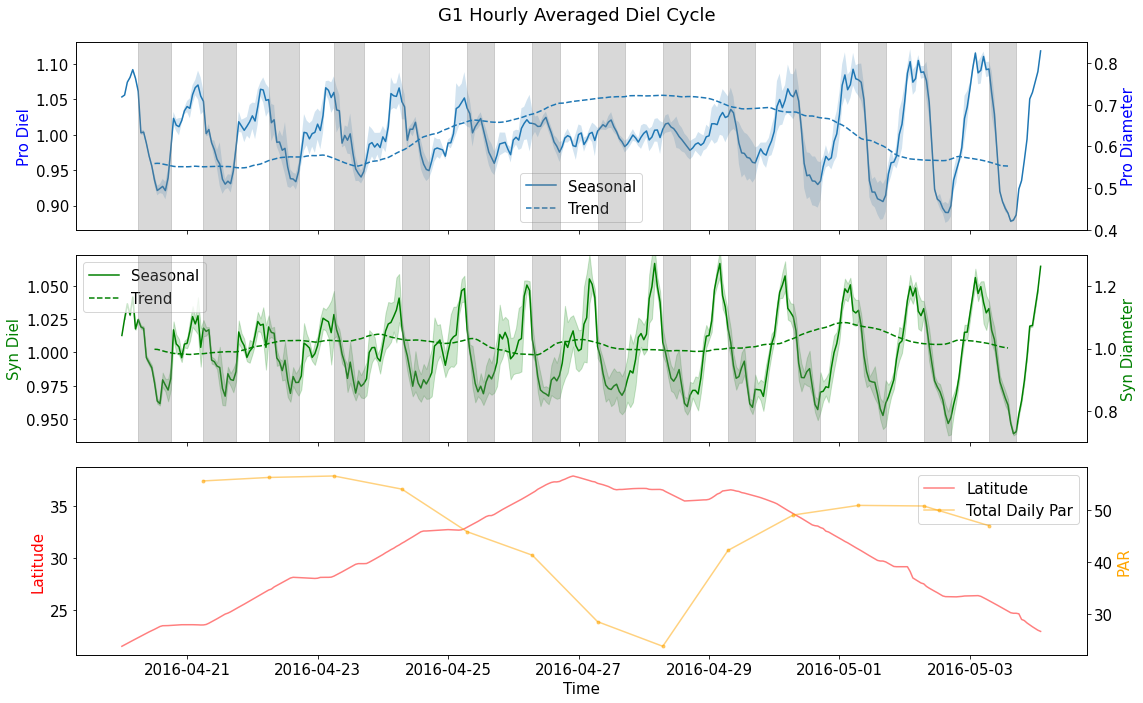

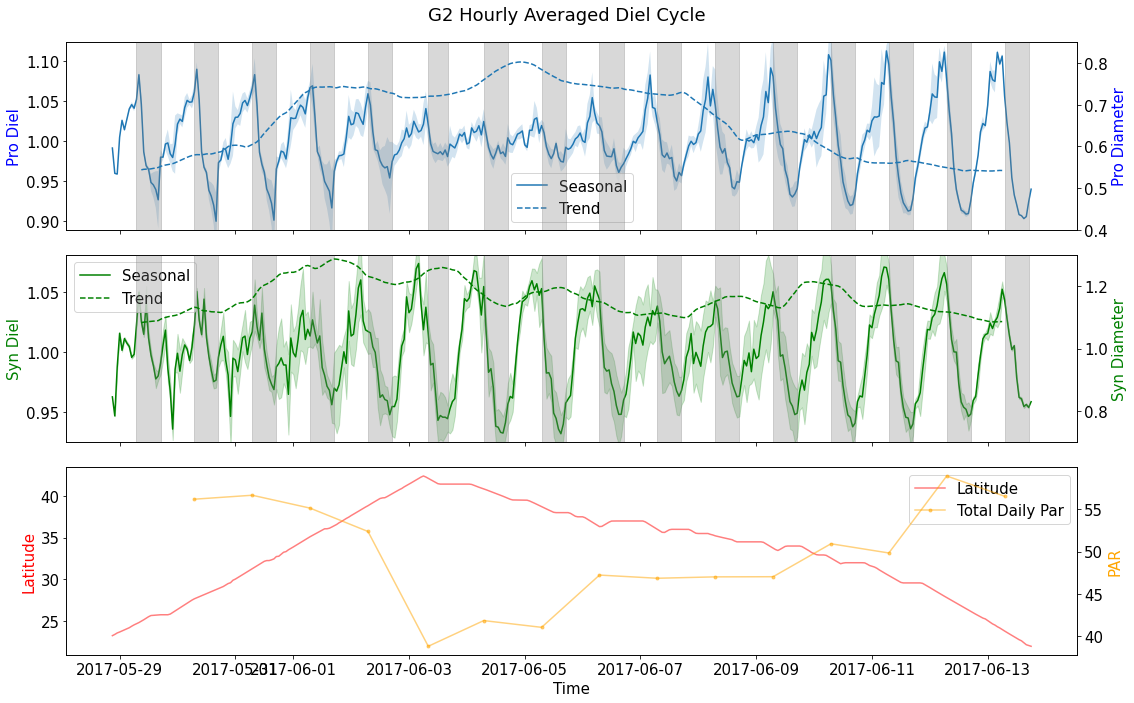

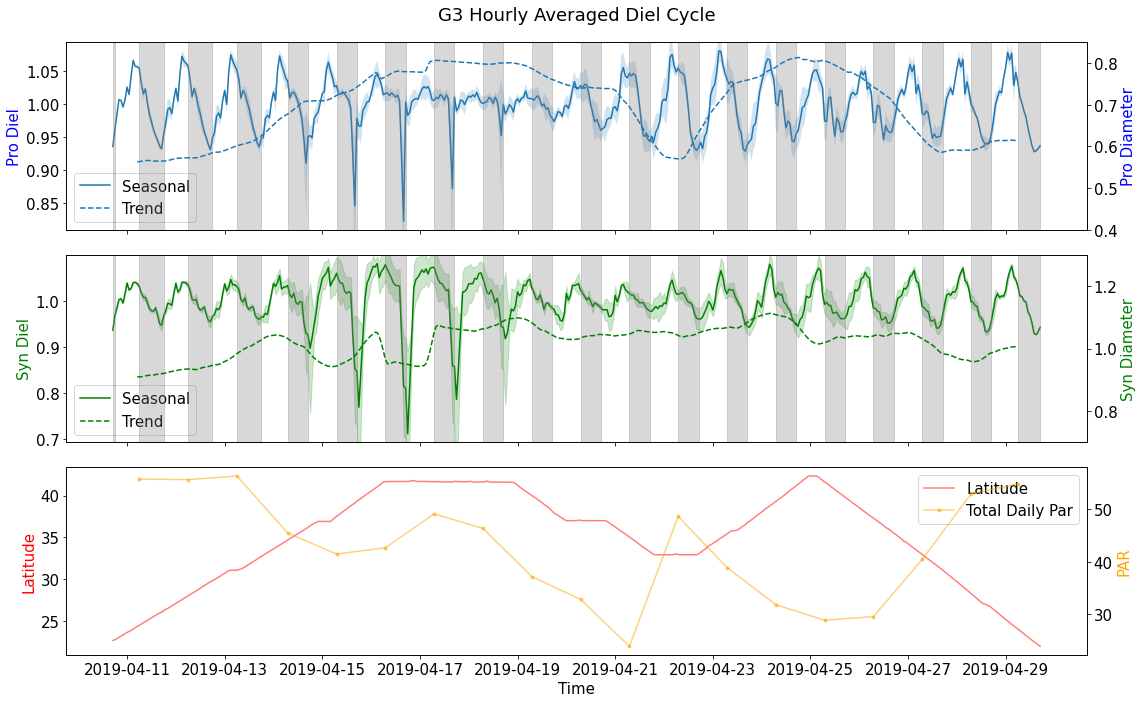

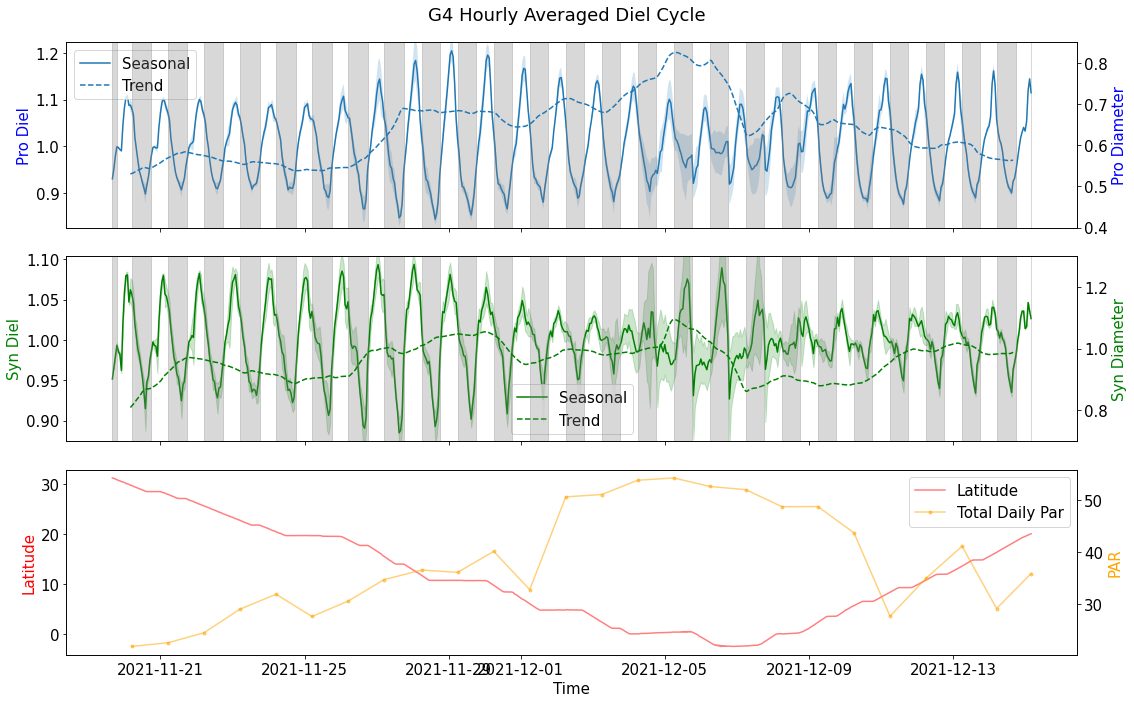

In [169]:
# pull the gradients cruises from the cruise list
gradients = ['KOK1606','MGL1704','KM1906','TN397']
cruise_list = [long_sf.loc[long_sf['cruise']==n] for n in gradients]
names = ['G1','G2','G3','G4']

for cruise, name in zip(cruise_list, names):
    seasonal, trend, resid, diel, plot0 = run_TSD(cruise, name, False)

## Analyzing the model outputs
We can also use $S_t$ as a proxy for daily cellular growth rate, and we can estimate how much cell size has changed on a diel cycle with respect to different covariates. We can approximate the daily cellular growth rate by calculating the difference of the maximum and minimum cell size per day, which we'll call the daily amplitude.
$$Amplitude = max(S_t)_d - min(S_t)_d $$ for d = day in a cruise <br>
#### Let's try it with our colocalized temperature and salinity data.

G1
G2
G3
G4


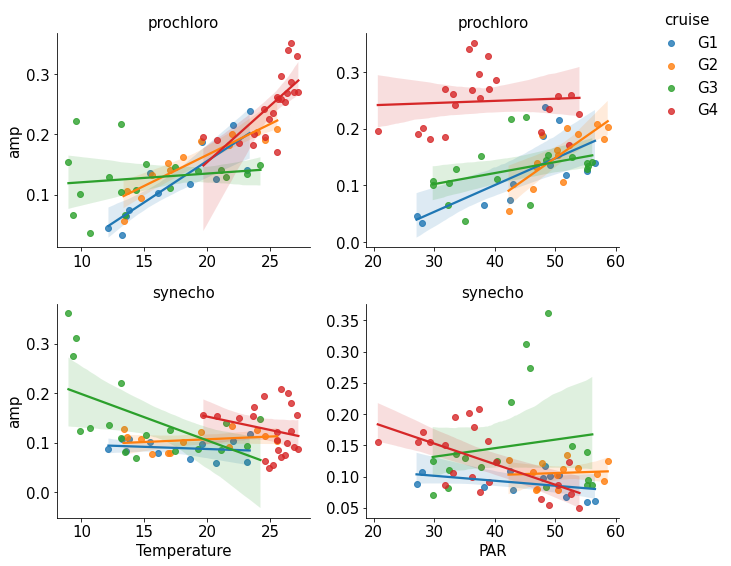

In [185]:
# run on gradients data
data = amp_temp(cruise_list, names, linreg=True)

### Temperature and PAR seem to have a relationship with Prochlorococcus. Let's try this same analysis on all the cruises with SeaFlow.

CN11ID
CN12ID
CN13ID
FK180310-1
FK180310-2
KM1427
KM1502
KM1508
KM1510
KM1512
KM1513
KM1518
KM1601
KM1602
KM1603
KM1708
KM1709
KM1712
KM1713
KM1717
KM1802
KM1821
KM1823
KM1901
KM1903
KM1906
KM1909
KM1912
KM1915
KM1917
KM1923_751
KM1924
KM2001
KM2002
KM2009
KM2010
KM2011
KM2013
KM2014
KM2101
KM2112
KN210-04
KOK1512
KOK1515
KOK1604
KOK1606
KOK1607
KOK1608
KOK1609
KOK1801
KOK1803
KOK1804
KOK1806
KOK1807
MGL1704
SR1917
TN271
TN292
TN397
TN398
Tokyo_3
Tokyo_4
TN248
TN280


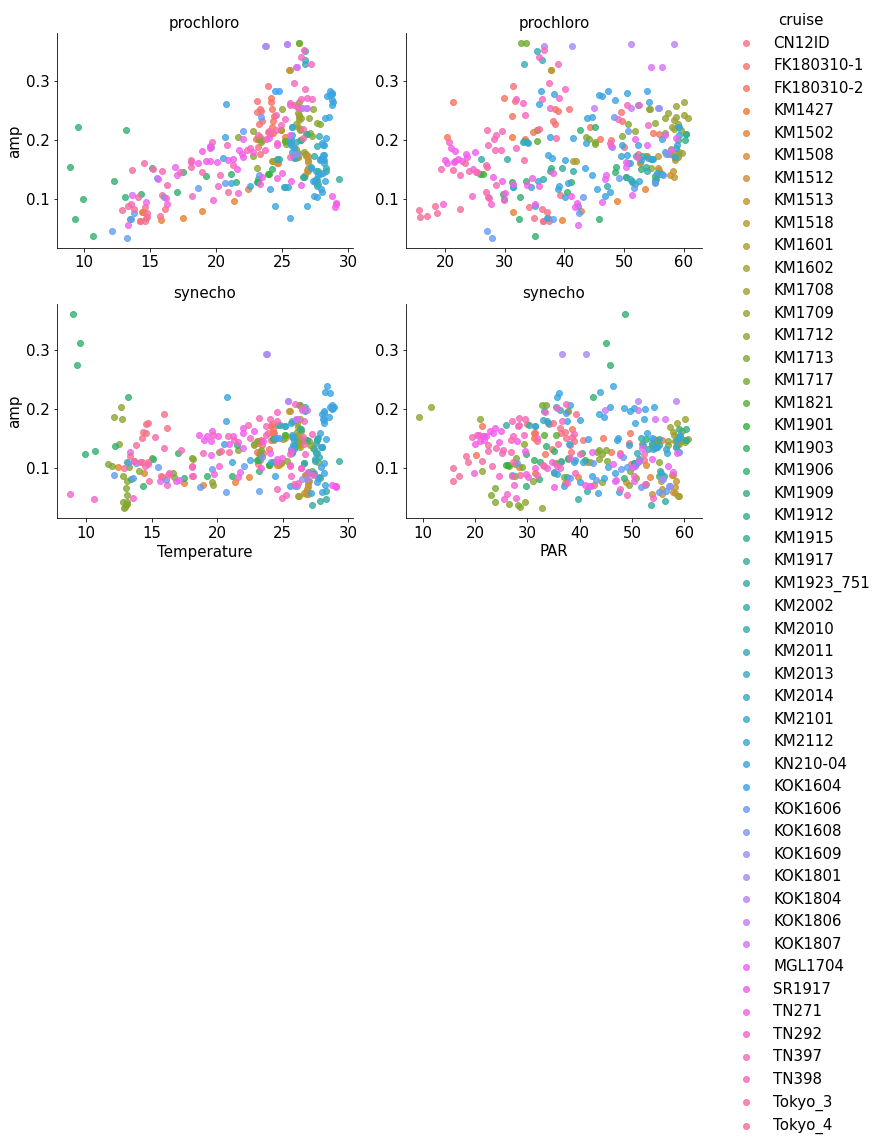

In [186]:
# run on all cruises in colocalized CMAP dataset
all_cruise_list = [long_sf.loc[long_sf['cruise']==n] for n in pd.unique(long_sf['cruise'])]
all_names = pd.unique(long_sf['cruise'])
data = amp_temp(all_cruise_list, all_names, linreg=False)

### Results:
For daily Prochlorococcus growth and temperature, there is an increase with daily growth until ~26-27ºC. This could be associated Prochlrococcus being limited by a thermal tolerance and slowing theri daily growth. Synechococcus does not seem to as strongly affected by temperature, and daily PAR effects seem to be weaker as well for both populations.